In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import os, sys

# Add to path the parent directory of this notebook dir

sys.path.append(os.path.dirname(os.getcwd()))
from view import plot_gamblers_value_function, plot_gamblers_policy
from policy_iteration import policy_evaluation_v, find_optimal_policy_q
from value_iteration import value_iteration_q

In [62]:
import gymnasium as gym
import numpy as np
from typing import Tuple


class GamblersProblemEnv(gym.Env):
    """
    Gambler's Problem environment.
    """

    def __init__(self, goal_amount: int = 100, win_probability: float = 0.4):
        """
        Initialize the environment.

        Args:
            goal_amount (int): The goal capital amount to be achieved.
            win_probability (float): Probability of winning a bet.
        """
        self.goal_amount = goal_amount
        self.win_probability = win_probability

        # Action space: bet an amount from 0 to the current capital
        # Observation space: current capital amount
        self.action_space = gym.spaces.Discrete(goal_amount + 1)
        self.observation_space = gym.spaces.Discrete(goal_amount + 1)

        self.state = None
        self.reset()

    def step(self, action: int) -> Tuple[int, float, bool, dict]:
        """
        Execute one time step within the environment.

        Args:
            action (int): Amount of capital to bet.

        Returns:
            Tuple containing the new state, reward, done flag, and additional info.
        """
        assert self.action_space.contains(action), "Invalid action"

        done = False
        reward = 0

        # Win case
        if np.random.rand() < self.win_probability:
            self.state += action
            if self.state >= self.goal_amount:
                self.state = self.goal_amount
                reward = 1
                done = True
        else:
            # Lose case
            self.state -= action
            if self.state <= 0:
                self.state = 0
                done = True

        truncated = False
        return self.state, reward, done, truncated, {}

    def reset(self) -> int:
        """
        Reset the environment to an initial state.

        Returns:
            The initial state.
        """
        self.state = 1  # Start with capital of $1
        return self.state

    def render(self, mode="human"):
        """
        Render the environment.
        """
        if mode == "human":
            print(f"Current Capital: ${self.state}")
        elif mode == "ansi":
            return f"Current Capital: ${self.state}"
        else:
            raise NotImplementedError("Render mode not supported: " + mode)
        
    def build_mdp(self):
        """
        Build the MDP representation for the Gambler's Problem.
        """
        t_r_dict = {}

        for state in range(1, self.goal_amount):  # States from 1 to goal_amount - 1
            for action in range(1, min(state, self.goal_amount - state) + 1):  # Possible bets
                # Winning scenario
                win_state = min(state + action, self.goal_amount)
                win_reward = 1 if win_state == self.goal_amount else 0
                t_r_dict[(state, action)] = (win_state, win_reward, win_state == self.goal_amount)

                # Losing scenario
                lose_state = max(state - action, 0)
                lose_reward = 0
                t_r_dict[(state, -action)] = (lose_state, lose_reward, lose_state == 0)

        return t_r_dict


In [63]:
# Create an instance of the environment
env = GamblersProblemEnv(goal_amount=100, win_probability=0.4)

# Generate the MDP representation
t_r_dict = env.build_mdp()
t_r_dict

{(1, 1): (2, 0, False),
 (1, -1): (0, 0, True),
 (2, 1): (3, 0, False),
 (2, -1): (1, 0, False),
 (2, 2): (4, 0, False),
 (2, -2): (0, 0, True),
 (3, 1): (4, 0, False),
 (3, -1): (2, 0, False),
 (3, 2): (5, 0, False),
 (3, -2): (1, 0, False),
 (3, 3): (6, 0, False),
 (3, -3): (0, 0, True),
 (4, 1): (5, 0, False),
 (4, -1): (3, 0, False),
 (4, 2): (6, 0, False),
 (4, -2): (2, 0, False),
 (4, 3): (7, 0, False),
 (4, -3): (1, 0, False),
 (4, 4): (8, 0, False),
 (4, -4): (0, 0, True),
 (5, 1): (6, 0, False),
 (5, -1): (4, 0, False),
 (5, 2): (7, 0, False),
 (5, -2): (3, 0, False),
 (5, 3): (8, 0, False),
 (5, -3): (2, 0, False),
 (5, 4): (9, 0, False),
 (5, -4): (1, 0, False),
 (5, 5): (10, 0, False),
 (5, -5): (0, 0, True),
 (6, 1): (7, 0, False),
 (6, -1): (5, 0, False),
 (6, 2): (8, 0, False),
 (6, -2): (4, 0, False),
 (6, 3): (9, 0, False),
 (6, -3): (3, 0, False),
 (6, 4): (10, 0, False),
 (6, -4): (2, 0, False),
 (6, 5): (11, 0, False),
 (6, -5): (1, 0, False),
 (6, 6): (12, 0, False

Optimal Policy: {1: 1, 2: 2, 3: 1, 4: 3, 5: 2, 6: 1, 7: 6, 8: 5, 9: 4, 10: 3, 11: 2, 12: 1, 13: 12, 14: 11, 15: 10, 16: 9, 17: 8, 18: 7, 19: 6, 20: 5, 21: 4, 22: 3, 23: 2, 24: 1, 25: 25, 26: 24, 27: 23, 28: 22, 29: 21, 30: 20, 31: 19, 32: 18, 33: 17, 34: 16, 35: 15, 36: 14, 37: 13, 38: 12, 39: 11, 40: 10, 41: 9, 42: 8, 43: 7, 44: 6, 45: 5, 46: 4, 47: 3, 48: 2, 49: 1, 50: 50, 51: 49, 52: 48, 53: 47, 54: 46, 55: 45, 56: 44, 57: 43, 58: 42, 59: 41, 60: 40, 61: 39, 62: 38, 63: 37, 64: 36, 65: 35, 66: 34, 67: 33, 68: 32, 69: 31, 70: 30, 71: 29, 72: 28, 73: 27, 74: 26, 75: 25, 76: 24, 77: 23, 78: 22, 79: 21, 80: 20, 81: 19, 82: 18, 83: 17, 84: 16, 85: 15, 86: 14, 87: 13, 88: 12, 89: 11, 90: 10, 91: 9, 92: 8, 93: 7, 94: 6, 95: 5, 96: 4, 97: 3, 98: 2, 99: 1}
Value Function: {1: {1: 0.5314410000000002, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 

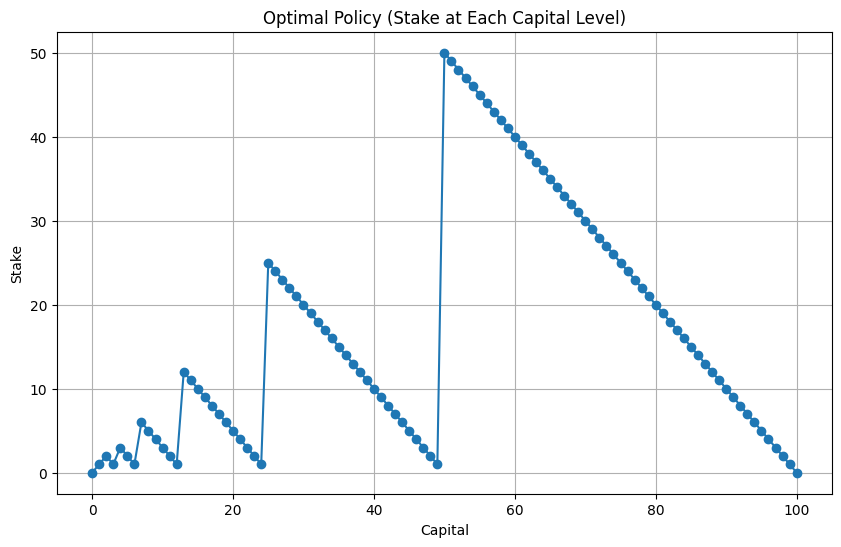

In [64]:
# Parameters for policy iteration
gamma = 0.9
theta = 1e-6

# Find the optimal policy using Q-value iteration
optimal_policy, optimal_value_function_q = find_optimal_policy_q(t_r_dict)

print("Optimal Policy:", optimal_policy)
print("Value Function:", optimal_value_function_q)

# Extract V from Q
states = list(set([s for s, _ in t_r_dict.keys()]))
V = {state: 0 for state in states}
optimal_V = policy_evaluation_v(states, optimal_policy, V, t_r_dict, gamma, theta)
print("Optimal Value Function:", optimal_V)

plot_gamblers_policy(optimal_policy, max_capital=env.goal_amount)

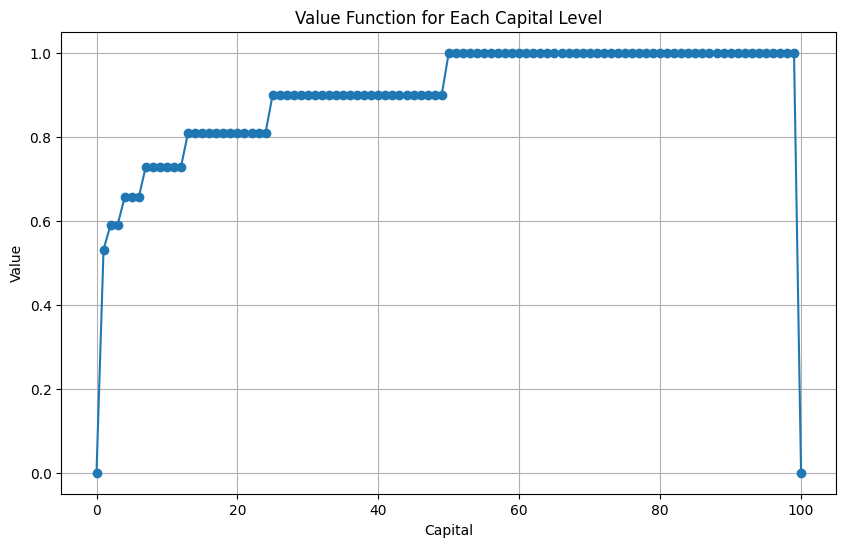

In [65]:
plot_gamblers_value_function(optimal_V, max_capital=env.goal_amount)

Optimal Policy: {1: 1, 2: 2, 3: 1, 4: 3, 5: 2, 6: 1, 7: 6, 8: 5, 9: 4, 10: 3, 11: 2, 12: 1, 13: 12, 14: 11, 15: 10, 16: 9, 17: 8, 18: 7, 19: 6, 20: 5, 21: 4, 22: 3, 23: 2, 24: 1, 25: 25, 26: 24, 27: 23, 28: 22, 29: 21, 30: 20, 31: 19, 32: 18, 33: 17, 34: 16, 35: 15, 36: 14, 37: 13, 38: 12, 39: 11, 40: 10, 41: 9, 42: 8, 43: 7, 44: 6, 45: 5, 46: 4, 47: 3, 48: 2, 49: 1, 50: 50, 51: 49, 52: 48, 53: 47, 54: 46, 55: 45, 56: 44, 57: 43, 58: 42, 59: 41, 60: 40, 61: 39, 62: 38, 63: 37, 64: 36, 65: 35, 66: 34, 67: 33, 68: 32, 69: 31, 70: 30, 71: 29, 72: 28, 73: 27, 74: 26, 75: 25, 76: 24, 77: 23, 78: 22, 79: 21, 80: 20, 81: 19, 82: 18, 83: 17, 84: 16, 85: 15, 86: 14, 87: 13, 88: 12, 89: 11, 90: 10, 91: 9, 92: 8, 93: 7, 94: 6, 95: 5, 96: 4, 97: 3, 98: 2, 99: 1}
Value Function: {1: {1: 0.5314410000000002, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 

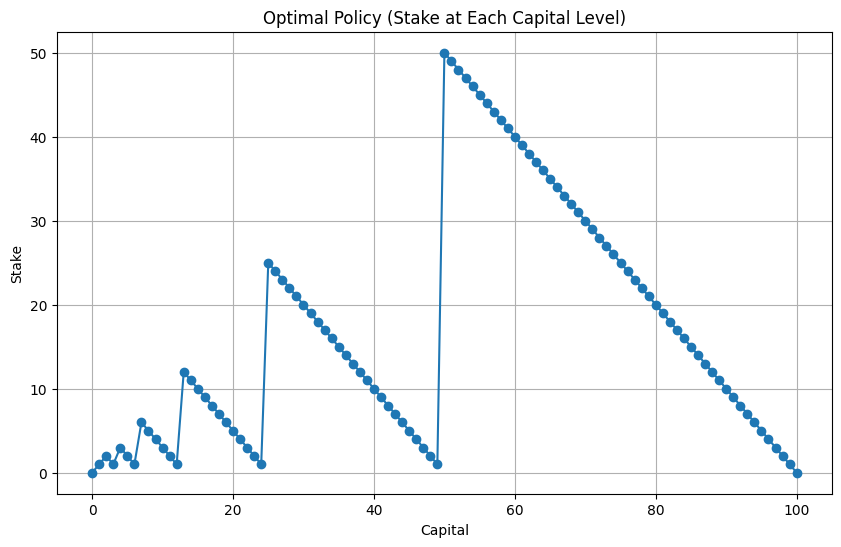

In [72]:

gamma = 0.9
theta = 1e-6

states = list(set([s for s, _ in t_r_dict.keys()]))
actions = list(set([a for _, a in t_r_dict.keys()]))

optimal_policy, optimal_value_function = value_iteration_q(t_r_dict, states, actions)

print("Optimal Policy:", optimal_policy)
print("Value Function:", optimal_value_function)

plot_gamblers_policy(optimal_policy, max_capital=env.goal_amount)